In [ ]:
# Install required YOLO
# !pip install ultralytics

# Load Data


In [1]:
# !mkdir -p ./data/sets/nuimages  # Make the directory to store the nuImages dataset in.

# !pip install nuscenes-devkit &> /dev/null  # Install nuImages.

# !wget https://www.nuscenes.org/data/nuimages-v1.0-mini.tgz  # Download the nuImages mini split.

# !tar -xf nuimages-v1.0-mini.tgz -C ./data/sets/nuimages  # Uncompress the nuImages mini split.

## Load Samples


In [2]:
# !wget https://d36yt3mvayqw5m.cloudfront.net/public/nuimages-v1.0/nuimages-v1.0-all-samples.tgz

# !tar -xf nuimages-v1.0-all-samples.tgz -C ./data/sets/nuimages  # Uncompress the entire nuImages samples.

## Load Metadata


In [3]:
# !wget https://d36yt3mvayqw5m.cloudfront.net/public/nuimages-v1.0/nuimages-v1.0-all-metadata.tgz

# !tar -xf nuimages-v1.0-all-metadata.tgz -C ./data/sets/nuimages  # Uncompress the entire nuImages metadata.

In [4]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import json
import shutil
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path
import torch
import yaml

# Überprüfen der verfügbaren Hardware
print(f"PyTorch version: {torch.__version__}")
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.6.0.dev20241112
Using device: mps


In [5]:
# Pfad zum NuImages-Datensatz (lokal)
DATA_SET_PATH = "data/sets/nuimages"

# Ausgabepfad für die YOLO-Trainingsdaten
output_path = "data/nuimages_yolo"
os.makedirs(output_path, exist_ok=True)

# Pfad zum vortrainierten YOLO-Modell
yolo_model_path = "yolo11n.pt"

# Filter attributes we're interested in
vehicles = [
    "vehicle.car",
    "vehicle.motorcycle",
    "vehicle.truck",
    "vehicle.trailer",
    "vehicle.bus.rigid",
]

# Classes in YOLO format: car=2, motorcycle=3, bus=5, truck=7
class_mapping = {
    "vehicle.car": 2,
    "vehicle.motorcycle": 3,
    "vehicle.bus.rigid": 5,
    "vehicle.truck": 7,
    "vehicle.trailer": 7,
}

In [6]:
from nuimages import NuImages
from tqdm import tqdm
import os

nuim = NuImages(dataroot=DATA_SET_PATH, version="v1.0-mini", verbose=True, lazy=True)
SAMPLES = nuim.sample
SAMPLES = SAMPLES[:100]
selected_sample = SAMPLES[0]

token = selected_sample["token"]
key_camera_token = selected_sample["key_camera_token"]

print("Selected Sample: ", selected_sample)

Loading nuImages tables for version v1.0-mini...
Done loading in 0.000 seconds (lazy=True).
Loaded 50 sample(s) in 0.000s,
Selected Sample:  {'token': '09acd654cb514bdeab8e3afedad74fca', 'timestamp': 1535352274870176, 'log_token': '4ed5d1230fcb48d39db895f754e724f9', 'key_camera_token': '0128b121887b4d0d86b8b1a43ac001e9'}


In [7]:
selected_sample_data = nuim.get("sample_data", key_camera_token)
print(selected_sample_data)

Loaded 650 sample_data(s) in 0.003s,
{'token': '0128b121887b4d0d86b8b1a43ac001e9', 'sample_token': '09acd654cb514bdeab8e3afedad74fca', 'ego_pose_token': 'f83112287e5447989a725a81d2417350', 'calibrated_sensor_token': 'e5c70a90001a5e9eb581dc010d13b11c', 'filename': 'samples/CAM_FRONT_RIGHT/n013-2018-08-27-14-41-26+0800__CAM_FRONT_RIGHT__1535352274870176.jpg', 'fileformat': 'jpg', 'width': 1600, 'height': 900, 'timestamp': 1535352274870176, 'is_key_frame': True, 'prev': '24614975bbb34bf385559d958df8008b', 'next': '5bdc01f564a14f0196817df2a53a41da'}


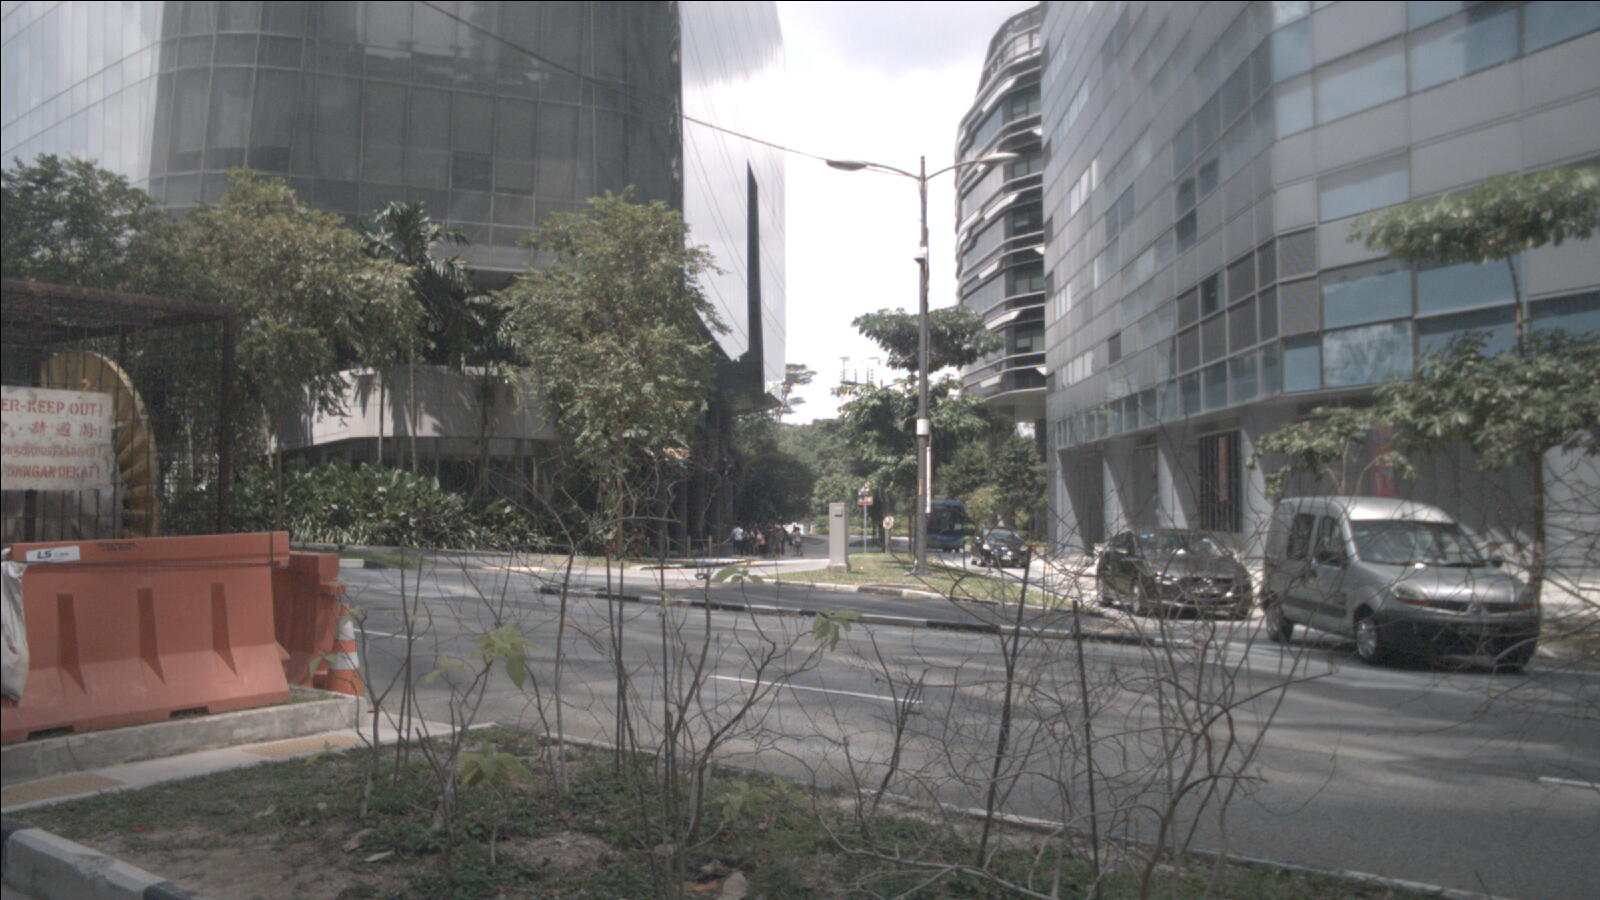

In [8]:
filename = DATA_SET_PATH + "/" + selected_sample_data["filename"]

from IPython.display import Image

Image(filename)

In [9]:
object_tokens, _ = nuim.list_anns(token, verbose=False)
print(object_tokens[0])
object_info = nuim.get("object_ann", object_tokens[0])
print(object_info)
annotation_category = nuim.get("category", object_info["category_token"])
print(annotation_category)

Loaded 506 object_ann(s) in 0.002s,
Loaded 58 surface_ann(s) in 0.001s,
Loaded 25 category(s) in 0.000s,
06eed0ca8b164b84bbb2851de1ed2c13
{'token': '06eed0ca8b164b84bbb2851de1ed2c13', 'category_token': 'fd69059b62a3469fbaef25340c0eab7f', 'bbox': [1096, 529, 1254, 621], 'mask': {'size': [900, 1600], 'counts': 'YmZUbjBfMWRqMDJNM04xTzJNM04yTjAwMU8wTzJPMDAxTzAwMU5NNDFPMTAwTzJOMTAwTzEwME8yTjEwME8xTzEwMU4xMDAwMDAwMDpGMDAxTzAwMU8wMDFPMDAxTzAwMDAwMDAwMDAwMDAwMDAwMDAwTjJNM08xMDAwMDAwMDAwMDAwMU8wMDAwMDAwMDAwMDAxTzAwMDAwMDAwMDAwMDAwMDAxTzAwMDAwMDAwMDAwMDAwMk4zTU8xMDBPMTAwMDBPMTAwTzEwMDAwTzEwME8xMDFPMDAwMDAwMDAwMDFOMTAwMDAwMDAxTzAwMDAwMDAwMDAxTzJOMU8xTzJOMU8yTjFPMk4xTzFPMk8wM0wyTjAwMDFPMDAwMDAwNkoxTzFPMU8xTzFPMU8xTzFOMk4yTjJOM00zTTNMNEw0TDRMOUJQZV45'}, 'attribute_tokens': ['abc0f113547848a9baaa62096fca37f5'], 'sample_data_token': '0128b121887b4d0d86b8b1a43ac001e9'}
{'token': 'fd69059b62a3469fbaef25340c0eab7f', 'name': 'vehicle.car', 'description': 'Vehicle designed primarily for personal use, e.g.

## Filter for vehicle classes


Fontconfig warning: ignoring UTF-8: not a valid region tag
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/nuimages/utils/utils.py:71: UserWarning: No suitable fonts were found in your system. A default font will be used instead (the font size will not be adjustable).
  warnings.warn('No suitable fonts were found in your system. '


Loaded 12 attribute(s) in 0.000s,


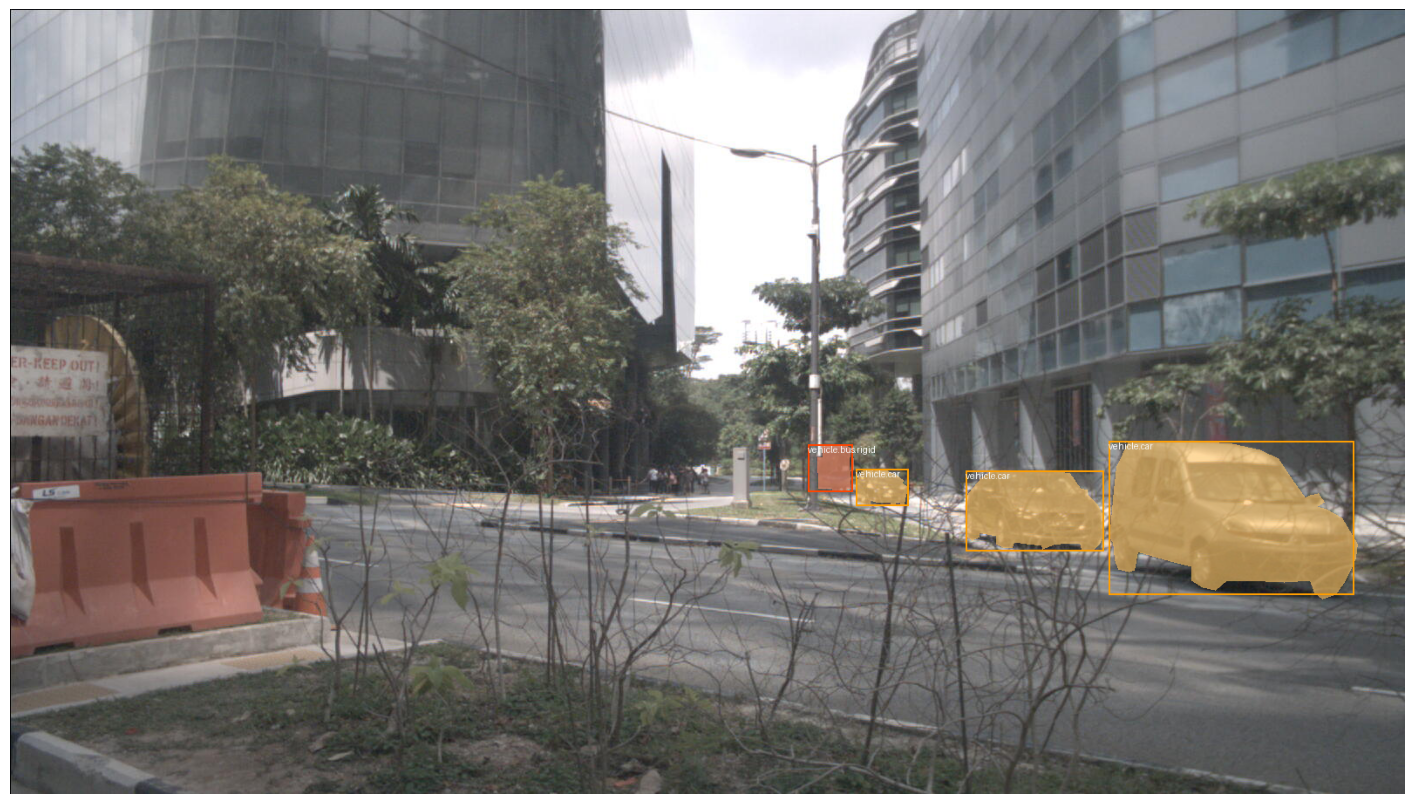

In [10]:
filtered_tokens = []
for token in object_tokens:
    object_info = nuim.get("object_ann", token)
    annotation_category = nuim.get("category", object_info["category_token"])
    if annotation_category["name"] in vehicles:
        filtered_tokens.append(token)

nuim.render_image(
    key_camera_token,
    with_category=True,
    object_tokens=filtered_tokens,
    surface_tokens=[],
    font_size=24,
    render_scale=2,
)

# Process Data


## Filter Front Camera(s) Images


In [11]:
# Front-Kamera-Bilder identifizieren (für Fahrzeuge, die sich wegbewegen)
def filter_front_camera_images(samples):
    """Filtert Bilder aus der Frontkamera."""
    front_camera_samples = []

    for sample in samples:
        key_camera_token = sample["key_camera_token"]
        sample_data = nuim.get("sample_data", key_camera_token)
        filename = sample_data["filename"]
        is_key_frame = sample_data["is_key_frame"]
        if is_key_frame and ("CAM_FRONT" in filename):
            front_camera_samples.append(sample)

    print(f"Gefunden: {len(front_camera_samples)} Bilder von Frontkameras")
    return front_camera_samples


filtered_samples = filter_front_camera_images(SAMPLES)

Gefunden: 20 Bilder von Frontkameras


## Get Image Annotations


In [12]:
vehicle_mapping = {
    "vehicle.car": 2,  # Original YOLO-Klasse für car
    "vehicle.motorcycle": 3,  # Original YOLO-Klasse für motorcycle
    "vehicle.bus.rigid": 5,  # Original YOLO-Klasse für bus
    "vehicle.truck": 7,  # Original YOLO-Klasse für truck
    "vehicle.trailer": 7,  # Trailer als Truck behandeln (keine eigene Klasse in YOLO)
}
# vehicle_mapping = {
#     "vehicle.car": 0,
#     "vehicle.motorcycle": 1,
#     "vehicle.bus.rigid": 2,
#     "vehicle.truck": 3,
#     "vehicle.trailer": 3,
# }

# NuImages-Kategorien laden und filtern
categories = nuim.category
vehicle_categories = {}

for category in categories:
    # Wenn die Kategorie in unserem Mapping ist, speichern wir ihre Token-ID
    lower_name = category["name"].lower()
    if lower_name in vehicle_mapping:
        vehicle_categories[category["token"]] = {
            "name": lower_name,
            "yolo_id": vehicle_mapping[lower_name],
        }

print(f"Extrahierte Fahrzeugkategorien: {len(vehicle_categories)}")
for token, info in vehicle_categories.items():
    print(f"  - {info['name']}: (Original YOLO-ID: {info['yolo_id']})")

Extrahierte Fahrzeugkategorien: 5
  - vehicle.bus.rigid: (Original YOLO-ID: 5)
  - vehicle.car: (Original YOLO-ID: 2)
  - vehicle.motorcycle: (Original YOLO-ID: 3)
  - vehicle.trailer: (Original YOLO-ID: 7)
  - vehicle.truck: (Original YOLO-ID: 7)


In [13]:
annotations_by_sample = {}

for sample in tqdm(filtered_samples, desc="Extrahiere Annotationen"):
    sample_token = sample["token"]
    annotations_by_sample[sample_token] = []

    # Alle Objekt-Annotationen für dieses Sample abrufen
    object_tokens, _ = nuim.list_anns(sample_token, verbose=False)

    for object_token in object_tokens:
        ann = nuim.get("object_ann", object_token)
        category_token = ann["category_token"]

        # Prüfen, ob es eine Fahrzeugkategorie ist, die wir behalten wollen
        if category_token in vehicle_categories:
            # Bounding Box im Format [x1, y1, x2, y2] extrahieren
            bbox = ann["bbox"]

            # Kategorie-Information hinzufügen
            annotations_by_sample[sample_token].append(
                {
                    "category_token": category_token,
                    "yolo_id": vehicle_categories[category_token]["yolo_id"],
                    "bbox": bbox,
                }
            )

Extrahiere Annotationen: 100%|██████████| 20/20 [00:00<00:00, 19173.96it/s]


In [14]:
print(annotations_by_sample)

{'09acd654cb514bdeab8e3afedad74fca': [{'category_token': 'fd69059b62a3469fbaef25340c0eab7f', 'yolo_id': 2, 'bbox': [1096, 529, 1254, 621]}, {'category_token': 'fd69059b62a3469fbaef25340c0eab7f', 'yolo_id': 2, 'bbox': [970, 527, 1030, 569]}, {'category_token': 'fd69059b62a3469fbaef25340c0eab7f', 'yolo_id': 2, 'bbox': [1260, 495, 1541, 671]}, {'category_token': 'fedb11688db84088883945752e480c2c', 'yolo_id': 5, 'bbox': [915, 499, 966, 553]}], '0deae1f926c148378bbd871055df8b08': [{'category_token': '6021b5187b924d64be64a702e5570edf', 'yolo_id': 7, 'bbox': [810, 390, 1004, 503]}, {'category_token': 'dfd26f200ade4d24b540184e16050022', 'yolo_id': 3, 'bbox': [1457, 469, 1600, 552]}, {'category_token': 'dfd26f200ade4d24b540184e16050022', 'yolo_id': 3, 'bbox': [1316, 456, 1461, 546]}, {'category_token': 'fd69059b62a3469fbaef25340c0eab7f', 'yolo_id': 2, 'bbox': [551, 436, 585, 451]}, {'category_token': 'dfd26f200ade4d24b540184e16050022', 'yolo_id': 3, 'bbox': [910, 449, 1023, 519]}], '0e27f6e0a97

## YOLO Dataset Prepare


In [15]:
import os
from pathlib import Path

# 1. Erstelle die notwendigen Verzeichnisse für YOLO-Training
train_path = Path(output_path) / "train"
val_path = Path(output_path) / "val"
train_images_path = train_path / "images"
train_labels_path = train_path / "labels"
val_images_path = val_path / "images"
val_labels_path = val_path / "labels"


def recreate_dirs():
    # Clear train and val directories if they exist
    if train_path.exists():
        shutil.rmtree(train_path)
    if val_path.exists():
        shutil.rmtree(val_path)

    # Verzeichnisse erstellen
    for dir_path in [
        train_images_path,
        train_labels_path,
        val_images_path,
        val_labels_path,
    ]:
        dir_path.mkdir(parents=True, exist_ok=True)


recreate_dirs()

In [16]:
import random

# 2. Die Samples zwischen Training und Validierung aufteilen (80% / 20%)
random.seed(42)  # Für Reproduzierbarkeit
val_split = 0.2

filtered_samples = SAMPLES.copy()
random.shuffle(filtered_samples)
split_idx = int(len(filtered_samples) * (1 - val_split))
train_samples = filtered_samples[:split_idx]
val_samples = filtered_samples[split_idx:]

print(
    f"Training: {len(train_samples)} Samples, Validierung: {len(val_samples)} Samples"
)

Training: 40 Samples, Validierung: 10 Samples


In [17]:
import shutil
from tqdm.notebook import tqdm

# 3. Bilder kopieren und Annotations-Dateien erstellen
processed_samples = {"train": 0, "val": 0}
processed_annotations = {"train": 0, "val": 0}


# YOLO-Format-Funktion: Konvertiert BBox [xmin, ymin, xmax, ymax] zu [class_id, x_center, y_center, width, height]
def convert_to_yolo_format(bbox, img_width, img_height, class_id):
    """
    Konvertiert Bounding Box von [xmin, ymin, xmax, ymax] zu YOLO-Format [x_center, y_center, width, height]
    Alle Werte werden auf Bildgröße normalisiert (0-1)
    """
    xmin, ymin, xmax, ymax = bbox

    # Normalisierte Breite und Höhe
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height

    # Normalisierte Zentrumskoordinaten
    x_center = (xmin + (xmax - xmin) / 2) / img_width
    y_center = (ymin + (ymax - ymin) / 2) / img_height

    return [class_id, x_center, y_center, width, height]


for dataset_type, samples in [("train", train_samples), ("val", val_samples)]:
    output_img_dir = train_images_path if dataset_type == "train" else val_images_path
    output_label_dir = train_labels_path if dataset_type == "train" else val_labels_path

    for sample in tqdm(samples, desc=f"Erstelle {dataset_type.capitalize()}-Dataset"):
        sample_token = sample["token"]
        key_camera_token = sample["key_camera_token"]

        # Bildpfad ermitteln
        sample_data = nuim.get("sample_data", key_camera_token)
        img_path = Path(DATA_SET_PATH) / sample_data["filename"]

        if not img_path.exists():
            print(f"Warnung: Bild {img_path} nicht gefunden, überspringe...")
            continue

        img_height, img_width = sample_data["height"], sample_data["width"]
        # img_height, img_width = img.shape[:2]

        # Zielbildpfad
        dest_img_name = f"{sample_token}.jpg"
        dest_img_path = output_img_dir / dest_img_name

        # # Bild kopieren
        # shutil.copy(img_path, dest_img_path)

        # Symbolischen Link erstellen anstatt das Bild zu kopieren
        # Absolute Pfade für Quell- und Zieldateien verwenden
        source_absolute = os.path.abspath(img_path)

        if os.path.lexists(dest_img_path):
            os.remove(dest_img_path)  # Entferne existierenden Symlink falls vorhanden

        os.symlink(source_absolute, dest_img_path)
        processed_samples[dataset_type] += 1

        # Annotationen im YOLO-Format erstellen
        annotations = annotations_by_sample.get(sample_token, [])
        if not annotations:
            # Leere Annotationsdatei erstellen, wenn keine Fahrzeuge vorhanden sind
            with open(output_label_dir / f"{sample_token}.txt", "w") as f:
                pass
            continue

        with open(output_label_dir / f"{sample_token}.txt", "w") as f:
            for ann in annotations:
                bbox = ann["bbox"]
                class_id = ann["yolo_id"]

                # Zu YOLO-Format konvertieren
                yolo_bbox = convert_to_yolo_format(
                    bbox, img_width, img_height, class_id
                )

                # In Datei schreiben: class_id x_center y_center width height
                f.write(
                    f"{yolo_bbox[0]} {yolo_bbox[1]:.6f} {yolo_bbox[2]:.6f} {yolo_bbox[3]:.6f} {yolo_bbox[4]:.6f}\n"
                )
                processed_annotations[dataset_type] += 1

# 4. YAML-Konfigurationsdatei für YOLO erstellen
yaml_content = {
    "path": os.path.abspath(output_path),
    "train": "train/images",
    "val": "val/images",
    "names": {
        2: "car",
        3: "motorcycle",
        5: "bus",
        7: "truck",
    },
}

with open(Path(output_path) / "dataset.yaml", "w") as f:
    yaml.dump(yaml_content, f, sort_keys=False)

print(f"\nDataset vorbereitet:")
print(
    f"- {processed_samples['train']} Trainingsbilder mit {processed_annotations['train']} Annotationen"
)
print(
    f"- {processed_samples['val']} Validierungsbilder mit {processed_annotations['val']} Annotationen"
)
print(f"- Konfiguration gespeichert in {Path(output_path) / 'dataset.yaml'}")

Erstelle Train-Dataset:   0%|          | 0/40 [00:00<?, ?it/s]

Erstelle Val-Dataset:   0%|          | 0/10 [00:00<?, ?it/s]


Dataset vorbereitet:
- 40 Trainingsbilder mit 70 Annotationen
- 10 Validierungsbilder mit 6 Annotationen
- Konfiguration gespeichert in data/nuimages_yolo/dataset.yaml


## Model Training


In [18]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import time

# Sicherstellen, dass der Ordner für die Trainingsergebnisse existiert
# results_dir = Path("results") / f"finetune_{time.strftime('%Y%m%d_%H%M%S')}"
# os.makedirs(results_dir, exist_ok=True)

# 1. Modell laden (vortrainiertes YOLOv11n)
print(f"Lade vortrainiertes Modell: {yolo_model_path}")
model = YOLO(yolo_model_path)

# 2. Training konfigurieren und starten
print(f"Starte Training mit Gerät: {device}")

# Parameter für das Training
results = model.train(
    data=str(Path(output_path) / "dataset.yaml"),
    # Grundlegende Trainingsparameter
    epochs=50,  # Anzahl der Trainingszyklen
    imgsz=640,  # Bildgröße (Standard für YOLOv11n)
    device=device,  # Verwendetes Gerät (mps, cuda, cpu)
)

WARNING ⚠️ torchvision==0.20 is incompatible with torch==2.6.
Run 'pip install torchvision==0.21' to fix torchvision or 'pip install -U torch torchvision' to update both.
For a full compatibility table see https://github.com/pytorch/vision#installation
Lade vortrainiertes Modell: yolo11n.pt
Starte Training mit Gerät: mps
New https://pypi.org/project/ultralytics/8.3.98 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data/nuimages_yolo/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid

RuntimeError: Dataset 'data/nuimages_yolo/dataset.yaml' error ❌ '4-class dataset requires class indices 0-3, but you have invalid class indices 2-7 defined in your dataset YAML.'

In [ ]:
# 3. Validierung des trainierten Modells
print("\nValidierung des finegetuned Modells:")
metrics = model.val()  # Validierung mit dem Validation-Set

# 4. Ergebnisse anzeigen
print(f"\nTrainingsergebnisse gespeichert in: {results_dir}/highway_model")

# 5. Plots anzeigen
try:
    # Ergebnisse visualisieren
    plt.figure(figsize=(16, 10))

    # Training-Plots erstellen
    for i, metric in enumerate(["box_loss", "cls_loss", "dfl_loss"]):
        plt.subplot(2, 3, i + 1)
        plt.plot(results.results_dict[metric], label=f"train {metric}")
        plt.plot(results.results_dict[f"val_{metric}"], label=f"val {metric}")
        plt.title(f"{metric}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

    # Metriken-Plots erstellen
    for i, metric in enumerate(["precision", "recall", "mAP50", "mAP50-95"]):
        plt.subplot(2, 3, i + 4)
        plt.plot(results.results_dict[metric], label=f"val {metric}")
        plt.title(f"{metric}")
        plt.xlabel("Epoch")
        plt.ylabel("Metric Value")
        plt.legend()

    plt.tight_layout()
    plt.savefig(f"{results_dir}/training_metrics.png", dpi=300)
    plt.show()

    print(f"Training-Metriken-Plot gespeichert: {results_dir}/training_metrics.png")
except Exception as e:
    print(f"Konnte Plots nicht erstellen: {e}")

# # 6. Bestes Modell für die spätere Verwendung speichern
# best_model_path = f"{results_dir}/highway_model/weights/best.pt"
# final_model_path = f"{results_dir}/best_highway_model.pt"

# if os.path.exists(best_model_path):
#     import shutil

#     shutil.copy(best_model_path, final_model_path)
#     print(f"Bestes Modell gespeichert unter: {final_model_path}")

#     # Informationen zum Modell ausgeben
#     print("\nModell ist bereit für die Inferenz:")
#     print(f"model = YOLO('{final_model_path}')")
#     print("predictions = model('pfad/zum/testbild.jpg')")